<a href="https://colab.research.google.com/github/acevedo-oscar/Generador-De-Imagenes-De-Bacteria/blob/master/Bio_WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!rm -r *


#!head MicrobiotaGAN/discriminator.py

In [2]:
!wget https://www.dropbox.com/s/c94s64a00k7m39y/MicrobiotaGAN.zip   # https://www.dropbox.com/s/0r8hjgj72h1tfmb/MicrobiotaGAN.zip;
!unzip MicrobiotaGAN.zip;

# !wget https://www.dropbox.com/s/yqw6vqbvt8m1g5g/images_1000_dataset.pickle 

!wget https://www.dropbox.com/s/prt4hgkfid37rok/5k_samples.zip;
    
!unzip 5k_samples.zip;
    
% ls

--2018-11-12 06:38:11--  https://www.dropbox.com/s/c94s64a00k7m39y/MicrobiotaGAN.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/c94s64a00k7m39y/MicrobiotaGAN.zip [following]
--2018-11-12 06:38:11--  https://www.dropbox.com/s/raw/c94s64a00k7m39y/MicrobiotaGAN.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uced5d5e6d42e6305e4d7e6a082b.dl.dropboxusercontent.com/cd/0/inline/AVaj5WYghBXehgnX7uEKK19dysSNySlTz80_IPZZCMnACV694tdSkpVRcaheWTf4GsCcrYpgK5oG7u5nSw4zneknhOQulv7HxDsLAttY2QRfzDM2dajE7jwSdPlkyDjPGyQ9gOcTkUZS0IW5uR2GeRJWzbICkcjYmn5nn37oAkn9qHrfPGfyUJCm-G19qj0dMms/file [following]
--2018-11-12 06:38:11--  https://uced5d5e6d42e6305e4d7e6a082b.dl.dropboxusercontent.com/cd/0/inline/AVaj5WYghBXehgnX7uEKK19dysSNySlTz80_

In [0]:
import tensorflow as tf 

from MicrobiotaGAN.generator import Generator
from MicrobiotaGAN.discriminator import Discriminator

from MicrobiotaGAN.cost import wasserstein_generator_cost
from MicrobiotaGAN.cost import wasserstein_discriminator_cost

from MicrobiotaGAN.xavier_initialization import xavier_init
from MicrobiotaGAN.input_noise_sample import input_noise_sample

from MicrobiotaGAN.dataset_manager import dataset_manager
from MicrobiotaGAN.display_microbiota import display_microbiota

from MicrobiotaGAN.utilities import *

In [0]:
import numpy as np

from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import pickle
import os

import seaborn as sns

sns.set()
from timeit import default_timer as timer


In [0]:
my_pickle = '5000_images_dataset.pickle' #'images_5000_dataset.pickle'

with open(my_pickle, 'rb') as pickleFile:
    microbiota_images = pickle.load(pickleFile)
    
    
param_path = 'image_dynamics_param.pickle' 

with open(param_path, 'rb') as pickleFile:
    microbiota_parameters = pickle.load(pickleFile)

In [0]:
# Load Data to the data mangaer

ds_table = unroll_dataset(microbiota_images)

microbiota_dataset =  dataset_manager(ds_table)

mbio_dict = ds_statistic_summary_dict(microbiota_images)



In [7]:
np.std(mbio_dict["max_vec"], ddof=1)  

35.44525350078432

In [8]:
microbiota_parameters.keys()

dict_keys(['N', 'rho', 'sigma', 'mu', 'T_f', 'A', 'r'])

Sigma: 0.6
Rho: 0.1
Distance from origin: 0.6082762530298219


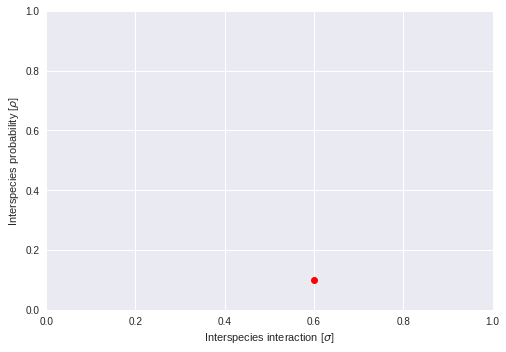

In [9]:
m_sigma = microbiota_parameters['sigma']
m_rho = microbiota_parameters['rho']
print("Sigma: "+str(m_sigma))
print("Rho: "+str(m_rho))

plt.axis(xmax=1, ymax=1)
plt.plot(m_sigma, m_rho,'ro')
 
plt.xlabel(r'Interspecies interaction [$\sigma$]') 
plt.ylabel(r'Interspecies probability [$\rho$]')

print("Distance from origin: "+ str(np.sqrt(m_rho**2 + m_sigma**2)))

Text(0.5,1,'A Matrix')

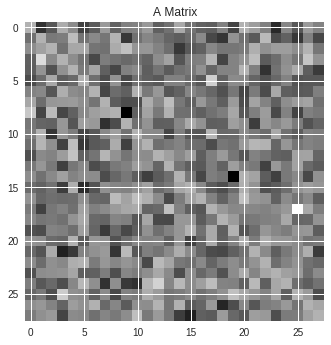

In [10]:
plt.imshow(microbiota_parameters['A'], cmap="gray_r")
plt.title("A Matrix")

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0,0.5,'Abundance')

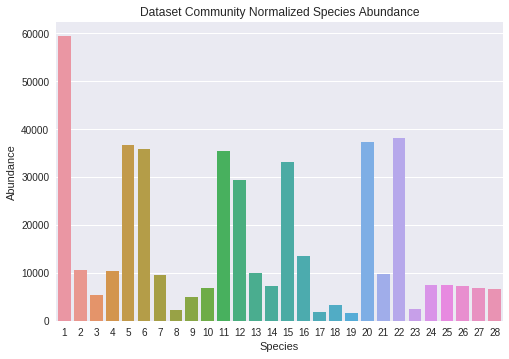

In [11]:
# Micorbiota abundance pseudo histogram

sns.barplot(x = list(range(1,29)) ,y= np.sum(normalize_ds(ds_table), axis=0))
plt.title("Dataset Community Normalized Species Abundance")
plt.xlabel("Species")
plt.ylabel("Abundance")


[0.1162, 0.1592, 0.3951, 0.0, 0.7319, 0.0, 0.0, 0.0, 0.0, 0.2398, 0.0, 0.0, 0.0, 0.1353, 1.0, 0.0, 0.268, 0.0, 0.0, 0.3353, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0162, 0.0, 0.0]


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0,0.5,'Abundance')

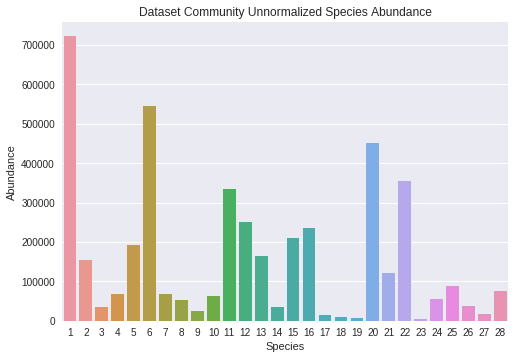

In [12]:
show_rounded_array(normalize_ds(ds_table)[3,:],4)
"""

n_samples = len(microbiota_images)
print("Training with "+str(n_samples))

print(type(microbiota_images))

remake = np.array(microbiota_images)

dim_remake = remake.shape

print(remake[0,:,:].shape)

print(dim_remake[0])

print(unroll_dataset(microbiota_images).shape)

"""

sns.barplot(x = list(range(1,29)) ,y= np.sum(ds_table, axis=0))
plt.title("Dataset Community Unnormalized Species Abundance")
plt.xlabel("Species")
plt.ylabel("Abundance")




In [0]:

n_species : int = 28
mini_batch_size : int =32

noise_dim : int = 10

# Computation Graph Definition
my_generator = Generator(noise_dim, n_species)
my_discriminator = Discriminator(noise_dim,n_species)

real_sample = tf.placeholder(tf.float32, shape=[None, n_species])
noise_sample = tf.placeholder(tf.float32, shape=[None, noise_dim])

generator_sample = my_generator.draw_samples(noise_sample)

D_real, D_logit_real = my_discriminator.get_probability_and_logit(real_sample)
D_fake, D_logit_fake = my_discriminator.get_probability_and_logit(generator_sample)

# Define the graph nodes related to the cost and omptimization operations
D_cost =  wasserstein_discriminator_cost(D_logit_real, D_logit_fake)
G_cost = wasserstein_generator_cost( D_logit_fake)

D_solver = my_discriminator.optimize_step(D_cost)
G_solver = my_generator.optimize_step(G_cost)

clip_D = my_discriminator.clip_parameters(0.01)


In [0]:
# Initialize the network graph
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [15]:
number_of_fig_per_plot :int = 16
#Training Loop
counter = 0
numero_de_iteraciones =   10000 #25000*4
start = timer()

g_cost_record = []
d_cost_record = []
iter_record_g = []
iter_record_d = []


g_cost_record = []
d_cost_record = []
epoch_record_g = []
epoch = []

d_iter_ratio: int = 5

for it in range(numero_de_iteraciones):
    
    # Train more the discrimantor    
    for k in range(d_iter_ratio):      
        
        #f k%5 == 0 and k != 0:
            #pass
        
        real_sample_mini_batch = microbiota_dataset.next_batch(mini_batch_size)
        dis_var_dict = {real_sample: real_sample_mini_batch, noise_sample: input_noise_sample(mini_batch_size, noise_dim)}
        _, D_current_cost, _ = sess.run([D_solver, D_cost, clip_D], feed_dict=dis_var_dict)
        d_cost_record.append(D_current_cost)
        iter_record_d.append(it+1+k)

    # End For



    # Apply the optimization algorithm and update both newtwork parameters
    gen_var_dict = {noise_sample: input_noise_sample(mini_batch_size, noise_dim)}
    _, G_current_cost = sess.run([G_solver, G_cost], feed_dict=gen_var_dict)    
    g_cost_record.append(G_current_cost)
    
    iter_record_g.append(it)

    if it % 1000 == 0:
        end = timer()
        print("Progreso :"+str(100*it/(1.0*numero_de_iteraciones))+" %")
        print(str(end - start)+" s")
        
        print(microbiota_dataset._epochs_completed)

        print('\t Iter: {}'.format(it))
        print('\t D loss: {:.4}'. format(D_current_cost))
        print('\t G_loss: {:.4}'.format(G_current_cost))



Progreso :0.0 %
0.2999935679999908 s
0
	 Iter: 0
	 D loss: 2.736e-09
	 G_loss: -1.863e-09
Progreso :10.0 %
7.23813182000049 s
1
	 Iter: 1000
	 D loss: -9.779e-09
	 G_loss: -5.937e-09
Progreso :20.0 %
14.209559726001316 s
2
	 Iter: 2000
	 D loss: -3.085e-09
	 G_loss: 1.281e-09
Progreso :30.0 %
21.154510166001273 s
3
	 Iter: 3000
	 D loss: -3.376e-09
	 G_loss: -4.366e-10
Progreso :40.0 %
28.064534416000242 s
4
	 Iter: 4000
	 D loss: 4.307e-09
	 G_loss: 3.26e-09
Progreso :50.0 %
35.0201726030009 s
5
	 Iter: 5000
	 D loss: 4.249e-09
	 G_loss: -4.497e-09
Progreso :60.0 %
41.92711718500141 s
6
	 Iter: 6000
	 D loss: 1.572e-09
	 G_loss: -2.678e-09
Progreso :70.0 %
48.901321110000936 s
8
	 Iter: 7000
	 D loss: 5.821e-09
	 G_loss: 4.191e-09
Progreso :80.0 %
55.79084325900112 s
9
	 Iter: 8000
	 D loss: -1.688e-09
	 G_loss: -4.657e-09
Progreso :90.0 %
62.74558368500038 s
10
	 Iter: 9000
	 D loss: -1.042e-08
	 G_loss: -5.632e-09


In [16]:
saver = tf.train.Saver()
saver.save(sess, '/content/bio_gan.ckpt')


'/content/bio_gan.ckpt'

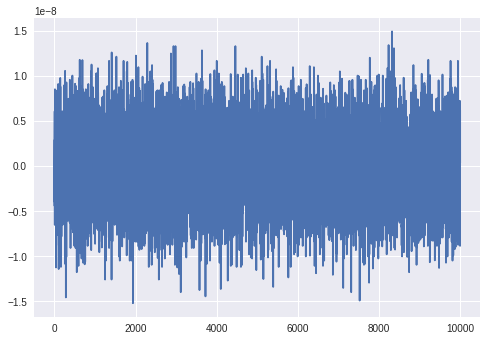

In [17]:
plt.plot(iter_record_g, g_cost_record)

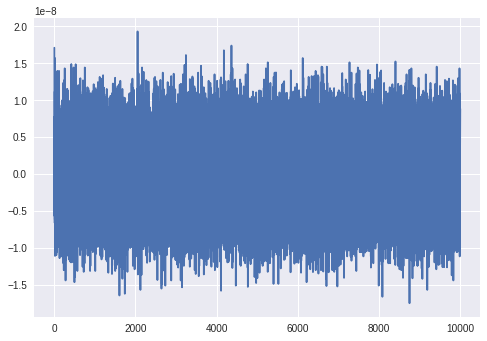

In [18]:
plt.plot(iter_record_d, d_cost_record)

In [19]:
"""
rand_index = np.random.randint(0,mini_batch_size)
real_s = real_sample_mini_batch[rand_index].reshape(28,28)
display_microbiota(real_s)

print( real_s[0:4,0:4])
print("\n")
print( random_sample[0:4,0:4])

"""

'\nrand_index = np.random.randint(0,mini_batch_size)\nreal_s = real_sample_mini_batch[rand_index].reshape(28,28)\ndisplay_microbiota(real_s)\n\nprint( real_s[0:4,0:4])\nprint("\n")\nprint( random_sample[0:4,0:4])\n\n'

In [0]:
#print(tf.get_default_graph().as_graph_def())

In [0]:
from google.colab import files


In [22]:

#Comprimimos todos los archivos que se regenraron al guardar el moelo y despues lo descargamos
!zip  bio_gan.zip bio_gan.*

files.download("bio_gan.zip")

  adding: bio_gan.ckpt.data-00000-of-00001 (deflated 14%)
  adding: bio_gan.ckpt.index (deflated 55%)
  adding: bio_gan.ckpt.meta (deflated 90%)


In [23]:
!ls

5000_images_dataset.pickle	  bio_gan.zip
5k_samples.zip			  checkpoint
bio_gan.ckpt.data-00000-of-00001  image_dynamics_param.pickle
bio_gan.ckpt.index		  MicrobiotaGAN
bio_gan.ckpt.meta		  MicrobiotaGAN.zip


In [24]:
ten = sess.run(my_generator.G_W1)
print(ten.shape)

(10, 128)


In [25]:
ten

array([[-0.9144704 , -0.11246235, -0.04354773, ..., -0.58963245,
         0.32423112, -1.2384686 ],
       [ 0.8466716 ,  0.67598844, -0.5400989 , ...,  0.05676891,
        -0.02494429, -0.61208314],
       [ 0.03649516,  0.19352181,  0.10490319, ...,  0.6020527 ,
        -0.5801329 , -1.054462  ],
       ...,
       [-0.7152741 ,  0.49215582, -0.95905447, ..., -0.38678357,
         0.3703632 ,  0.10125463],
       [-0.14425272, -0.79818   , -0.7866546 , ..., -0.3101148 ,
         0.26164   ,  0.1953249 ],
       [ 0.1118218 ,  1.0604227 , -0.9314081 , ..., -0.7171673 ,
         0.74945265,  0.2749267 ]], dtype=float32)

In [0]:
w1 = sess.run(my_generator.G_W1)
b1 = sess.run(my_generator.G_b1)

w2= sess.run(my_generator.G_W2)
b2 = sess.run(my_generator.G_b2)



gen_weights_and_bias = [w1, b1, w2, b2]

In [0]:
import pickle

In [0]:
with open('gen_param.pkl', 'wb') as f:
  pickle.dump(gen_weights_and_bias, f)

5000


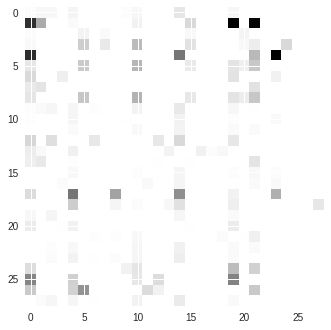

In [29]:
print(len(microbiota_images))
display_microbiota(microbiota_images[np.random.randint(5000)])

In [34]:
n_samples = 100
samples_table = []
for k in range(n_samples):
    s_noise = input_noise_sample(1,10)
    f_sam = sess.run(my_generator.draw_samples(s_noise, train_bool = False))
    samples_table.append(f_sam[0] )
    done_per =(k/(1.0*n_samples))*100
    #print(str(round(done_per,2))+"% has samples have been created")
    print(k)
    if k%(n_samples/1000)==0:
        print(str(done_per)+"% has samples have been created")
samples_table = np.array(samples_table)

FailedPreconditionError: ignored

In [112]:

sns.barplot(x = list(range(1,29)) ,y= np.sum(normalize_ds(samples_table), axis=0))
plt.title("GAN-Dataset Community Normalized Species Abundance")
plt.xlabel("Species")
plt.ylabel("Abundance")
plt.savefig("fake.svg")

IndexError: ignored

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


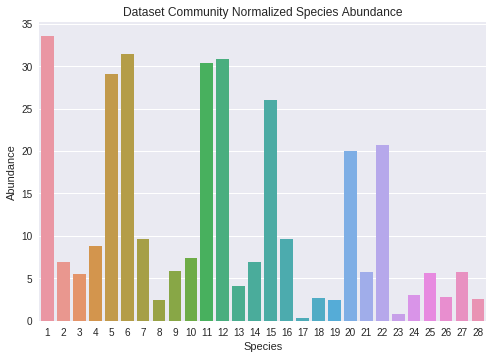

In [76]:

rnd_index = np.random.randint(low=1, high=140000,size=100)
sub_ds = normalize_ds(ds_table)[rnd_index]

sns.barplot(x = list(range(1,29)) ,y= np.sum(sub_ds, axis=0))
plt.title("Dataset Community Normalized Species Abundance")
plt.xlabel("Species")
plt.ylabel("Abundance")
plt.savefig("real.svg")
 

In [0]:
files.download("real.svg")
files.download("fake.svg")

In [0]:
a_t = normalize_ds(samples_table)

In [68]:
show_rounded_array(a_t[8,:],2)

[0.01, 0.0, 0.0, 0.0, 0.06, 0.29, 0.0, 0.01, 0.01, 0.0, 0.48, 0.0, 0.0, 0.0, 0.0, 0.02, 0.0, 0.0, 0.02, 0.01, 0.06, 1.0, 0.0, 0.0, 0.0, 0.0, 0.16, 0.0]


In [74]:
!l

5000_images_dataset.pickle	  checkpoint
5k_samples.zip			  gen_param.pkl
bio_gan.ckpt.data-00000-of-00001  image_dynamics_param.pickle
bio_gan.ckpt.index		  MicrobiotaGAN
bio_gan.ckpt.meta		  MicrobiotaGAN.zip
bio_gan.zip


In [32]:
!head -n 20 MicrobiotaGAN/generator.py

import tensorflow as tf

from MicrobiotaGAN.xavier_initialization import xavier_init

class Generator:

    def __init__(self,noise_dim : int ,n_species: int) -> None:
         
        nodes_input_layer : int = 128

        self.G_W1 = tf.Variable(xavier_init([noise_dim, nodes_input_layer]) , name="G_W1")
        self.G_b1 = tf.Variable(tf.zeros(shape=[nodes_input_layer]), name="G_b1" )

        self.G_W2 = tf.Variable(xavier_init([nodes_input_layer, n_species ]) , name="G_W2")
        self.G_b2 = tf.Variable(tf.zeros(shape=[n_species]) , name="G_b2")

    def  draw_samples(self, noise, train_bool: bool = True ) :
        

        G_h1 = tf.nn.relu(tf.matmul(noise, self.G_W1) + self.G_b1)


In [114]:
bool(1)

True

In [33]:
dir(my_generator)

['G_W1',
 'G_W2',
 'G_b1',
 'G_b2',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'draw_samples',
 'optimize_step']